<a href="https://colab.research.google.com/github/Mmoonniikk/ARPDATAPL-demo/blob/main/Kopia_notatnika_Computer_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importujemy potrzebne biblioteki


In [ ]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
!pip install --upgrade tensorflow-federated
from google.colab.patches import cv2_imshow

import tensorflow_federated as tff
import pickle


from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras.optimizers import SGD

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.3/68.3 MB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.5/103.5 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 kB 14.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 558.5/558.5 kB 56.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 MB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 65.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 58.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.8/255.8 kB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.9/238.9 kB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━

Pobieramy dataset

In [ ]:
(train, test) = tff.simulation.datasets.celeba.load_data(
    split_by_clients=True, cache_dir=None
)

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.12.0


Tworzenie zbioru danych test_ds z danych testowych pobranych ze wszystkich klientów

In [ ]:
test_ds = test.create_tf_dataset_from_all_clients()

Przypisanie do x zmiennej "image", a do y "male" oraz konwersja 0-255 do 0-1, zmiana "male" z wartości true, false na 0/1.


In [ ]:
test=test_ds.map(lambda x: (x['image']/255, 1 if x['male'] else 0))

In [ ]:
test_X = test_ds.map(lambda x: x['image'])  # obraz
test_y = test_ds.map(lambda x: x['male'])  # jedna etykieta

In [ ]:
train_ds = train.create_tf_dataset_from_all_clients()

In [ ]:
train=train_ds.map(lambda x: (x['image']/255, 1 if x['male'] else 0))


In [ ]:
train_X = train_ds.map(lambda x: x['image'])  # obraz
train_y = train_ds.map(lambda x: x['male'])  # jedna etykieta

wyświetlenie jednego przykłądowego obrazu

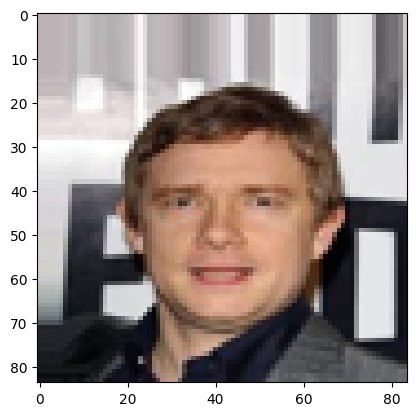

In [ ]:
plt.imshow(elem.numpy())
plt.show()

Zaimportowanie potrzebnych metod z biblioteki Tensorflow

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical

Budujemy model

In [ ]:

model = Sequential()
model.add(Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same',
                 input_shape=(84,84,3)))
model.add(Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(64, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(64, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(128, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(128, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2,2)))

model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(1, activation='sigmoid'))

Przypisanie liczby epok

In [ ]:
num_epochs=20

Rozmiar wsadu ustawiamy na 1024

In [ ]:
train = train.batch(1024)


In [ ]:
test = test.batch(1024)

kompilacja modelu oraz jego wytrenowanie

In [ ]:


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


history = model.fit(train,
                   epochs=num_epochs, verbose=True,
                   validation_data=(test))

Epoch 1/20
177/177 [==============================] - 257s 721ms/step - loss: 0.5878 - accuracy: 0.7516 - val_loss: 0.4315 - val_accuracy: 0.7845
Epoch 2/20
177/177 [==============================] - 129s 728ms/step - loss: 0.1555 - accuracy: 0.9376 - val_loss: 0.1110 - val_accuracy: 0.9573
Epoch 3/20
177/177 [==============================] - 134s 754ms/step - loss: 0.1040 - accuracy: 0.9591 - val_loss: 0.0991 - val_accuracy: 0.9630
Epoch 4/20
177/177 [==============================] - 126s 710ms/step - loss: 0.0887 - accuracy: 0.9658 - val_loss: 0.0991 - val_accuracy: 0.9632
Epoch 5/20
177/177 [==============================] - 126s 713ms/step - loss: 0.0793 - accuracy: 0.9695 - val_loss: 0.1019 - val_accuracy: 0.9635
Epoch 6/20
177/177 [==============================] - 125s 705ms/step - loss: 0.0716 - accuracy: 0.9727 - val_loss: 0.0953 - val_accuracy: 0.9672
Epoch 7/20
177/177 [==============================] - 126s 708ms/step - loss: 0.0632 - accuracy: 0.9765 - val_loss: 0.0870 -